In [9]:
pip install -q tensorflow-model-optimization

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import load_model
import numpy as np
import tensorflow_model_optimization as tfmot
import keras.datasets as dataset
import matplotlib.pyplot as plt
import tempfile
import pickle as pk

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
# load dataset
cifar = dataset.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
num_classes = 10
train_labels = np_utils.to_categorical(train_labels,num_classes)
test_labels = np_utils.to_categorical(test_labels,num_classes)

In [12]:
def build_model(input_shape,output_shape):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

def NNZ(weights):
  zeroCount = 0
  for ele in weights:
    if ele == 0.0:
      zeroCount += 1

  return zeroCount

In [13]:
model = build_model(input_shape=train_images.shape[1:], 
                    output_shape=num_classes)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [14]:
# fit model
history = model.fit(
  train_images,
  train_labels,
  epochs=100,
  validation_data=(test_images,test_labels),
)

Epoch 1/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5344 - accuracy: 0.4406 - val_loss: 1.2047 - val_accuracy: 0.5770
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1172 - accuracy: 0.6028 - val_loss: 0.9540 - val_accuracy: 0.6673
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9613 - accuracy: 0.6586 - val_loss: 0.8134 - val_accuracy: 0.7203
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8757 - accuracy: 0.6920 - val_loss: 0.7943 - val_accuracy: 0.7192
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8220 - accuracy: 0.7115 - val_loss: 0.9066 - val_accuracy: 0.6889
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7792 - accuracy: 0.7277 - val_loss: 0.7266 - val_accuracy: 0.7466
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7376 - accuracy: 0.7414 - val_loss: 0.7486 - val_ac

Baseline test accuracy: 0.792900025844574


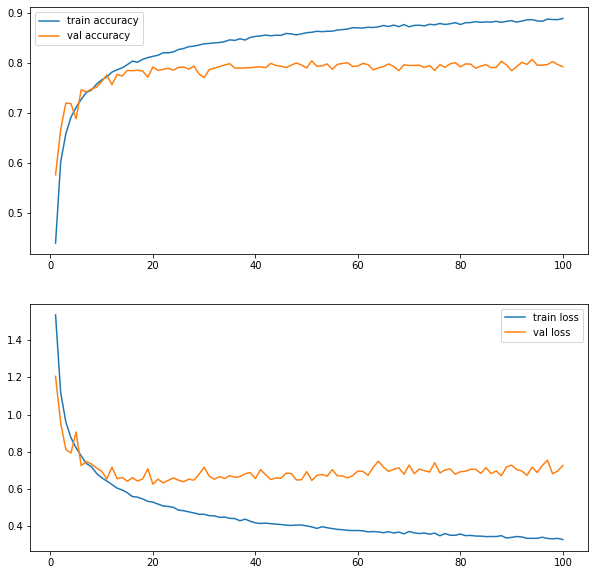

In [15]:
# plots
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.arange(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='train accuracy')
plt.plot(np.arange(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(1,len(history.history['loss'])+1),history.history['loss'],label='train loss')
plt.plot(np.arange(1,len(history.history['val_loss'])+1),history.history['val_loss'],label='val loss')
_=plt.legend()
_, baseline_model_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)

In [16]:
dir_name = '/content/gdrive/My Drive/Fall20/10617_IDL/Project/baseline/'

# save model
model.save(dir_name+'baseline-model.h5')

# save metrics
metric = (history.history['accuracy'],history.history['val_accuracy'],
          history.history['loss'],history.history['val_loss'])
fname = 'metric.pkl'
with open(dir_name+fname,'wb') as f:
  pk.dump(metric,f)
f.close()

In [17]:
# Get the number of non-zeros params
allWeights = np.array([1],dtype=float)
for weight in model.get_weights():
  allWeights = np.concatenate((allWeights,weight.flatten()))
nnz = NNZ(allWeights[1:])
print("Number of Non-zero Params: ", nnz)
print("Sparsity - {d}%".format(d=np.round(nnz/allWeights[1:].shape[0]*100,2)))

Number of Non-zero Params:  0
Sparsity - 0.0%
